# OBIA and deeplearning for image classification in Python
Packages used in the project:
- GDAL==2.0.1
- numpy>=1.10,<1.11
- scipy==0.17.0
- scikit-learn==0.17
- docopt==0.6.2
- matplotlib==1.5.1
- jupyter==1.0.0


In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import os
import numpy as np
import scipy
import cv2
from spectral import *
from pylab import *
from osgeo import gdal
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from matplotlib import colors
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from google.colab import drive

plt.style.use('seaborn-ticks')
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import skimage
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve2d

def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_Int16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def print_cm(cm, labels):
    """pretty print for confusion matrix"""
    # https://gist.github.com/ClementC/acf8d5f21fd91c674808
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}s".format(columnwidth) % round(cm[i, j], 3), end="\t")
        print()


def segment_features(segment_pixels):
    '''#Training data: here We transform each training segment into
      a segment model and thus creating the training dataset.'''
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features


def estimate_noise(I):
    # Ref: Fast Noise Variance Estimation
    H, W = I.shape
    M = [[1, -2, 1],
        [-2, 4, -2],
        [1, -2, 1]]
    
    sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
    sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))
    return sigma


def fix_small_segments(segments, window_size=15, max_iterations=5, min_size=1):
        # This skimage function assigns label "0" to small objects
        small_objs = skimage.morphology.remove_small_objects(segments,
                                                             min_size=min_size,
                                                             connectivity=1,
                                                             in_place=False
                                                             )
        small_objs_idxs = np.where(small_objs == 0)
        fixed_segments = np.copy(segments)
        iterations = 0
        while len(small_objs_idxs[0]) > 0 and iterations < max_iterations:
            w = int(window_size/2)
            for i, (row, col) in enumerate(zip(*small_objs_idxs)):
                r1 = max(0, row-w)
                c1 = max(0, col-w)
                r2 = min(segments.shape[0], row+w+1)
                c2 = min(segments.shape[1], col+w+1)
                block = fixed_segments[r1:r2, c1:c2]
                mode, _ = scipy.stats.mode(block[block > 0], axis=None)
                if len(mode) > 0 and mode[0] != 0:
                    fixed_segments[row, col] = mode[0]

            fixed_segments = skimage.morphology.remove_small_objects(
                fixed_segments, min_size=2, connectivity=1, in_place=False)
            small_objs_idxs = np.where(fixed_segments == 0)
            iterations += 1

        return fixed_segments


def write_geotiff(fname, data, datype, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, datype)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

In [ ]:
# Import images and training data sets
img_file = "/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Input_Images/KSR_20150709_Sub_TIF.tif"
# img_rgb = "/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Input_Images/KSR_20150709_Sub_TIF.tif"

train_path = "/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/train_uav_point"
test_path = "/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/test_uav_point"
#img_pca = "/content/gdrive/My Drive/Colab Notebooks/Species_classification/20160623_HSI_PCA.tif"
#img_text = "/content/gdrive/My Drive/Colab Notebooks/Species_classification/20160623_HSI_text.tif"
# img_file = "/content/gdrive/My Drive/Colab Notebooks/Species_classification/20160623_HSI.tif"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in multiply
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


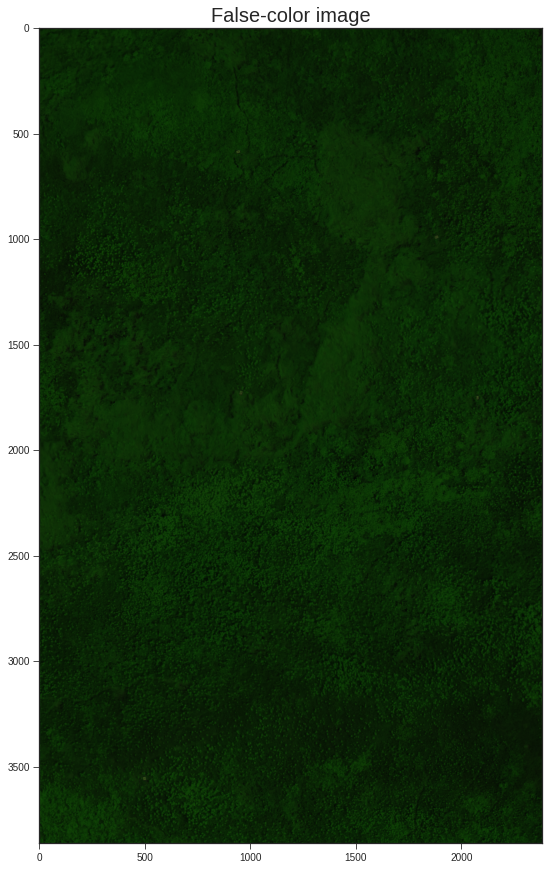

In [ ]:
#Read raster dataset and stack image bands
raster_dataset = gdal.Open(img_file, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
n_bands = raster_dataset.RasterCount

# Load full image
hsi_img = np.moveaxis(raster_dataset.ReadAsArray()[:3], 0, -1)
rgb_img = np.dstack((hsi_img[:,:,1], hsi_img[:,:,0], hsi_img[:,:,2]))
# rgb_img = exposure.rescale_intensity(rgb_img).astype('uint8')
# rgb_img = np.dstack((rgb_uav[:,:,2], rgb_uav[:,:,1], rgb_uav[:,:,0]))

# Rescale the pixel values to 8-bit (0-255)
hsi_img = hsi_img*1000
hsi_img = hsi_img.astype('uint8')
# hsi_img = np.dstack((np.moveaxis(raster_dataset.ReadAsArray()[:251], 0, -1), img_texture))

# Plot color image
plt.figure(figsize=(20, 15))
plt.imshow(rgb_img, alpha=1)
plt.title('False-color image', fontsize=20)
plt.xticks()
plt.yticks()
plt.show()

In [ ]:
# #%%time
# # Dimentionality reduction using PCA
# pca = principal_components(hsi_img)
# pca_999 = pca.reduce(fraction=0.9999)
# hsi_999 = pca_999.transform(hsi_img)

# print(len(pca_999.eigenvalues))
# hsi_999 = hsi_999.real
# hsi_3com = np.dstack(([hsi_999[:,:,0], hsi_999[:,:,1]]))

# # Plot results
# fig, ax = plt.subplots(1, 2, figsize=(20,8))
# ax[0].imshow((hsi_3com[:,:,0]), cmap=plt.cm.gray)
# ax[1].imshow((hsi_3com[:,:,1]), cmap=plt.cm.gray)
# #ax[2].imshow((hsi_3com[:,:,2]), cmap=plt.cm.gray)
# fig.tight_layout()
# for ax in ax.ravel():
#     ax.axis("off")
# plt.show()


/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


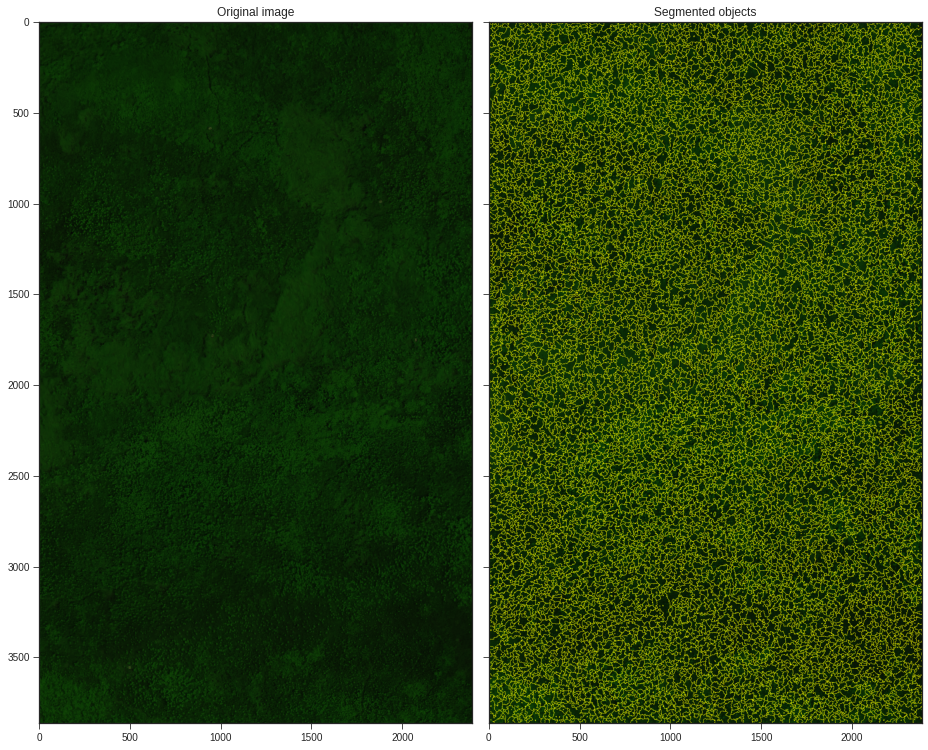

In [ ]:
#%%time
# 3-band Watershed image segmentation using gradient
from skimage.morphology import watershed
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel
from skimage import color

gradient = sobel(color.rgb2gray(hsi_img))
segments_ws = watershed(gradient, markers = 25000, connectivity=1, compactness = 1e-6)
segments_ws = fix_small_segments(segments_ws, window_size = 3, max_iterations = 5, min_size = 10)

fig, axes = plt.subplots(ncols=2, figsize=(13, 15), sharex=True, sharey=True)

ax = axes.ravel()
ax[0].imshow(rgb_img)
ax[0].set_title('Original image')
ax[1].imshow(mark_boundaries(rgb_img, segments_ws, mode="outter", color=(1, 1, 0),))
ax[1].set_title('Segmented objects')

fig.tight_layout()

plt.show()

In [ ]:
# #%%time
# # All-band Watershed image segmentation using gradient
# from skimage.morphology import watershed, opening, closing, square, disk, erosion
# # from skimage.morphology import diameter_closing
# from skimage.segmentation import mark_boundaries, join_segmentations
# from skimage.filters import sobel
# from skimage import color, measure
# from skimage.restoration import estimate_sigma
# from skimage import morphology
# import cv2

# # Segment and combine resulted segmentation for all the bands using Watershed
# # Estimate noise for each band
# noise_0 = estimate_noise(hsi_img[:,:,0])
# gradient_sum = sobel(hsi_img[:,:,0])
# gradient_sum = gradient_sum*(1/noise_0)

# for i in range(1, hsi_img.shape[2]):
#     noise_i = estimate_noise(hsi_img[:,:,i])
#     gradient_i = sobel(hsi_img[:,:,i])*(1/noise_i)
#     gradient_sum = cv2.add(gradient_sum, gradient_i)

# gradient_sum = closing(gradient_sum, square(3))
# segments_ws = watershed(gradient_sum, markers=15000, connectivity=1, compactness = 1e-6)

# # Merge segment of less than 10 pixels to large segment
# segments_ws = fix_small_segments(segments_ws, window_size = 3, max_iterations = 5, min_size = 10)

# # Plot the segmented results
# fig, axes = plt.subplots(ncols=2, figsize=(13, 15), sharey=True)

# ax = axes.ravel()
# ax[0].imshow(rgb_img)
# ax[0].set_title('Original image')
# ax[1].imshow(mark_boundaries(rgb_img, segments_ws, mode='outer', outline_color=(1, 1, 0),))
# ax[1].set_title('Segmented objects')

# fig.tight_layout()
    
# plt.show()

In [ ]:
# #%%time
# # All-band Watershed image segmentation (with region merging) using gradient
# from scipy import ndimage as ndi
# from skimage.morphology import watershed
# from skimage.segmentation import mark_boundaries, join_segmentations
# from skimage.filters import sobel
# from skimage import color, measure


# # Segment and combine resulted segmentation for all the bands using Watershed
# n_bands = hsi_img.shape[2]
# gradient = sobel(hsi_img[:,:,0])

# segments_ws = watershed(gradient, markers=15000, connectivity=1, compactness = 1e-6)
# # segments_ws = fix_small_segments(segments_ws, window_size=3, max_iterations=5, min_size=50)
# for i in range(1, n_bands):
#     gradient_i = sobel(hsi_img[:,:,i])
#     segments_i = watershed(gradient_i, markers=15000, connectivity=1, compactness = 1e-6)
#     segments_ws = join_segmentations(segments_ws, segments_i)

# segments_ws = fix_small_segments(segments_ws, window_size=1, max_iterations=5, min_size=10)

# # Calculate the mean of object in the segmented image
# # segments_ws_rgb = color.label2rgb(segments_ws, rgb_img, kind='avg')

# fig, axes = plt.subplots(ncols=2, figsize=(13, 15), sharex=True, sharey=True)

# ax = axes.ravel()
# ax[0].imshow(rgb_img)
# ax[0].set_title('Original image')
# ax[1].imshow(mark_boundaries(rgb_img, segments_ws, mode='outter', color=(1, 1, 0),))
# ax[1].set_title('Segmented objects')

# fig.tight_layout()
    
# plt.show()

In [ ]:
# We choose the watershed segmentation
segments = segments_ws
segment_ids = np.unique(segments)
print("Number of segmens: %i segments." % len(segment_ids))

Number of segmens: 15756 segments.


In [ ]:
# Import training data from shapefiles
rows, cols, n_bands = hsi_img.shape
files = [f for f in os.listdir(train_path) if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(train_path, f) for f in files if f.endswith('.shp')]
for i in range(0, len(classes_labels)):
  print(shapefiles[i])

# Calculate the number of classes in the training data
ground_truth = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
classes = np.unique(ground_truth)[1:]  # 0 doesn't count
print("Number of classes: ", len(classes))

# Calculate the number of segment in each class
segments_per_clas = {}
for clas in classes:
    segments_of_clas = segments[ground_truth==clas]
    segments_per_clas[clas] = set(segments_of_clas)
    print("Training segments for class %i: %i" % (clas, len(segments_per_clas[clas])))

/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/train_uav_point/Brome_dense.shp
/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/train_uav_point/Brome_spar.shp
/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/train_uav_point/Fescue.shp
/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/train_uav_point/Goldenrod.shp
/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/train_uav_point/Milkweed.shp
Number of classes:  5
Training segments for class 1: 48
Training segments for class 2: 29
Training segments for class 3: 27
Training segments for class 4: 39
Training segments for class 5: 56


In [ ]:
# Disambiguation: Check if there are segments which contain training pixels of different classes
accum = set()
intersection = set()
for class_segments in segments_per_clas.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0


#¡No need to disambiguate!
Next, we will paint in black all segments that are not for training. The training segments will be painted of a color depending on the class.

To do that we'll set as threshold the max segment id (max segments image pixel value). Then, to the training segments we'll assign values higher than the threshold. Finally, we assign 0 (zero) to pixels with values equal or below the threshold.

In [ ]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for clas in classes:
    clas_label = threshold + clas
    for segment_id in segments_per_clas[clas]:
        train_img[train_img == segment_id] = clas_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

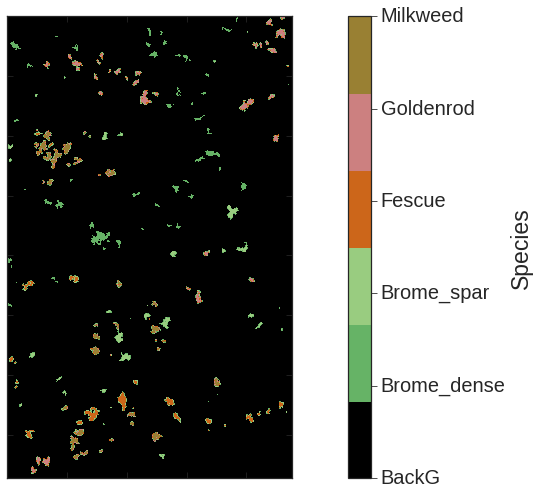

In [ ]:
# Display the training segments
plt.style.use('seaborn-ticks')

cm = np.array([[0,0,0], [0.4,0.7,0.4], [0.6,0.8,0.5], [0.8,0.4,0.1], [0.8,0.5,0.5], [0.6,0.5,0.2]])
cmap = colors.ListedColormap(cm)

plt.figure(figsize=(20, 8.5))

train_spl = plt.imshow(train_img, cmap=cmap)
cbar = plt.colorbar(train_spl, ticks=[0,1,2,3,4,5])
plt.tick_params(bottom=True, top=True, left=True, right=True, labelbottom=False, labelleft=False, direction='in')
cbar.set_label(label='Species', size=23)
cbar.ax.tick_params(labelsize=20, rotation=0, direction = 'out', bottom=True)
cbar.ax.set_yticklabels(labels=['BackG', 'Brome_dense', 'Brome_spar', 'Fescue', 'Goldenrod', 'Milkweed'], va="center")

# Export classification results to TIFF raster file
datype = gdal.GDT_Byte
output_fname = "/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/training_data.tif"
write_geotiff(output_fname, train_img, datype, geo_transform, proj)


Create all the objects:

compute the features' vector for each segment (and append the segment ID as reference)

In [ ]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = hsi_img[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)

    print("Created %i objects" % len(objects))

Created 15756 objects


In [ ]:
# Subset the training data
training_labels = []
training_objects = []
for clas in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_clas[clas]]
    training_labels += [clas] * len(class_train_objects)
    print("Training samples for class %i: %i" % (clas, len(class_train_objects)))
    training_objects += class_train_objects

Training samples for class 1: 48
Training samples for class 2: 29
Training samples for class 3: 27
Training samples for class 4: 39
Training samples for class 5: 56


In [ ]:
# Load test data and create label for validation
shapefiles = [os.path.join(test_path, "%s.shp"%c) for c in classes_labels]
verification_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)
for_verification = np.nonzero(verification_pixels)
verification_labels = verification_pixels[for_verification]

for i in range(0, len(classes_labels)):
  print(shapefiles[i])

# Calculate the number of classes in the test data
classes = np.unique(verification_pixels)[1:]  # 0 doesn't count
print("Number of classes: ", len(classes))

# Calculate the number of segment in each class
segments_per_clas = {}
for clas in classes:
    segments_of_clas = segments[verification_pixels==clas]
    segments_per_clas[clas] = set(segments_of_clas)
    print("Test segments for class %i: %i" % (clas, len(segments_per_clas[clas])))

test_img = np.copy(segments)
threshold = test_img.max() + 1
for clas in classes:
    clas_label = threshold + clas
    for segment_id in segments_per_clas[clas]:
        test_img[test_img == segment_id] = clas_label
test_img[test_img <= threshold] = 0
test_img[test_img > threshold] -= threshold

/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/test_uav_point/Brome_dense.shp
/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/test_uav_point/Brome_spar.shp
/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/test_uav_point/Fescue.shp
/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/test_uav_point/Goldenrod.shp
/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/test_uav_point/Milkweed.shp
Number of classes:  5
Test segments for class 1: 13
Test segments for class 2: 9
Test segments for class 3: 7
Test segments for class 4: 6
Test segments for class 5: 15


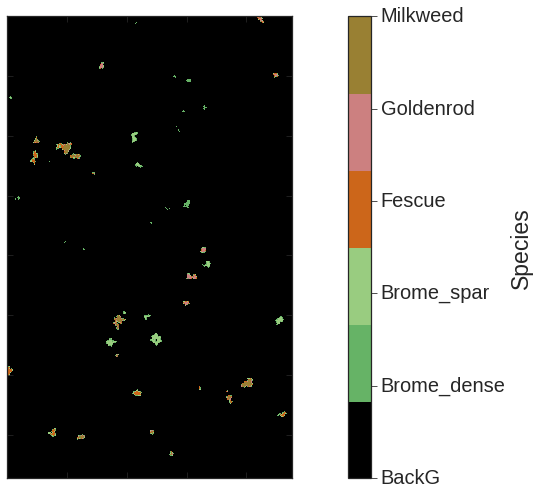

In [ ]:
# Display the test segments
plt.style.use('seaborn-ticks')

plt.figure(figsize=(20, 8.5))

test_spl = plt.imshow(test_img, cmap=cmap)
cbar = plt.colorbar(test_spl, ticks=[0,1,2,3,4,5])
plt.tick_params(bottom=True, top=True, left=True, right=True,labelbottom=False, labelleft=False, direction='in')
cbar.set_label(label='Species', size=23)
cbar.ax.tick_params(labelsize=20, rotation=0, direction = 'out', bottom=True)
cbar.ax.set_yticklabels(labels=['BackG', 'Brome_dense', 'Brome_spar', 'Fescue', 'Goldenrod', 'Milkweed'], va="center")

# Export classification results to TIFF raster file
datype = gdal.GDT_Byte
output_fname = "/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/test_data.tif"
write_geotiff(output_fname, test_img, datype, geo_transform, proj)


# Random Forest classification

In [ ]:
# Random Forest hyperparameter tuning using RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
import joblib
import pickle

start_time = time.time()

# Create the random grid
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rfr_grid = RandomizedSearchCV(estimator = RandomForestClassifier(),
                              param_distributions = random_grid,
                              n_iter = 10, cv = 10, verbose=2,
                              n_jobs = -1)

# Fit the random search model for the grid search
rfr_grid.fit(training_objects, training_labels)

# Print the tuning result and get the best parameters
print("The best parameters are %s with a score of %0.3f"
      % (rfr_grid.best_params_, rfr_grid.best_score_))

print("The best RandomForest model:")
print(rfr_grid.best_estimator_)

means = rfr_grid.cv_results_['mean_test_score']
for mean, params in zip(means, rfr_grid.cv_results_['params']):
    print("Score = %0.3f for %r"% (mean, params))

# Save the trained best rfr model as a pickle file
path_rfr = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/rfr_model.pkl'
joblib.dump(rfr_grid, open(path_rfr, 'wb'))

# Calculate and save the training time
end_time = time.time()
elapsed_time = (end_time - start_time)

path_rfr_time = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/rfr_time_model.txt'
with open(path_rfr_time, 'w', newline='') as txtfile:
  txtfile.write('Training time: ' + str(round(elapsed_time, 0)) + '\n')
  txtfile.write('Best model: ' + str(rfr_grid.best_params_) + '\n')
  txtfile.write('Best score: ' + str(rfr_grid.best_score_))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
The best parameters are {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False} with a score of 0.673
The best RandomForest model:
RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_leaf=2,
                       n_estimators=2000)
Score = 0.668 for {'n_estimators': 673, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
Score = 0.663 for {'n_estimators': 231, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}
Score = 0.632 for {'n_estimators': 673, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Score = 0.658 for {'n_estimators': 452, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}
Score = 0.648 for {'

In [ ]:
# Load the model and perform classification
path_rfr = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/rfr_model.pkl'
rfc_classifier =  joblib.load(open(path_rfr, 'rb'))
rfc_pred = rfc_classifier.predict(objects)

# Copy resultant segments
clf = np.copy(segments)
for segment_id, clas in zip(objects_ids, rfc_pred):
    clf[clf==segment_id] = clas

In [ ]:
# Calculate confusion matrix
# Plot confusion matrixfrom sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

predicted_labels = clf[for_verification]
cm = metrics.confusion_matrix(verification_labels, predicted_labels, normalize=None)
print_cm(cm, classes_labels)

kappa_rfr = cohen_kappa_score(verification_labels, predicted_labels)
Overall_acc = accuracy_score(verification_labels, predicted_labels)
print()
print("Overall Accuracy:", round(Overall_acc*100, 3))
print("Kappa Coefficient:", round(kappa_rfr, 3))

# Save runtime and accuracy to CSV
path_rfr_txt = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/rfr_accuracy.txt'
with open(path_rfr_txt, 'w', newline='') as txtfile:
  txtfile.write('Overall Accuracy: ' + str(round(Overall_acc*100, 3)) + '\n')
  txtfile.write('Kappa Coefficient: ' + str(round(kappa_rfr, 3)))

print()
print('----------------------------------------------------------------------------------------------------------------------------')
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,digits=3,
                                    target_names=classes_labels))

           	Brome_dense	 Brome_spar	     Fescue	  Goldenrod	   Milkweed	
Brome_dense	         12	          1	          0	          0	          0	
 Brome_spar	          3	          3	          1	          1	          1	
     Fescue	          0	          1	          4	          1	          1	
  Goldenrod	          0	          0	          0	          6	          0	
   Milkweed	          0	          1	          2	          1	         11	

Overall Accuracy: 72.0
Kappa Coefficient: 0.642

----------------------------------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

 Brome_dense      0.800     0.923     0.857        13
  Brome_spar      0.500     0.333     0.400         9
      Fescue      0.571     0.571     0.571         7
   Goldenrod      0.667     1.000     0.800         6
    Milkweed      0.846     0.733     0.786        15

    accuracy                          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


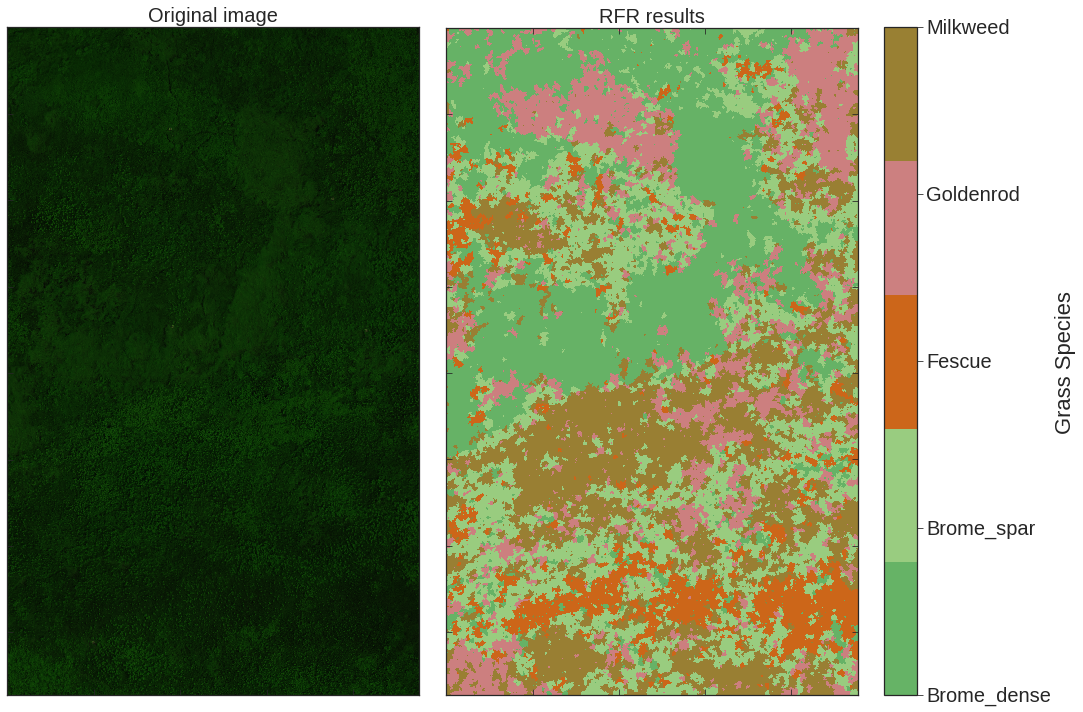

In [ ]:
# Display the RFR classification results
plt.style.use('seaborn-pastel')

clf_mask = clf

# Set up species colors on the map
cm_clas = np.array([[0.4,0.7,0.4], [0.6,0.8,0.5], [0.8,0.4,0.1], [0.8,0.5,0.5], [0.6,0.5,0.2]])
cmap_clas = colors.ListedColormap(cm_clas)

# Plot the classification result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10), sharey=True)
ax = axes.ravel()
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image', fontsize=20)
ax1.tick_params(labelbottom=False, labelleft=False, direction='in')  
clas_img = ax2.imshow(clf_mask, interpolation='none', cmap=cmap_clas)
ax2.set_title('RFR results', fontsize=20)
ax2.tick_params(bottom=True, top=True, left=True, right=True, labelbottom=False, labelleft=False, direction='in')   
cbar = plt.colorbar(clas_img, ticks=[1,2,3,4,5])
cbar.set_label(label="Grass Species", size=22)
cbar.ax.tick_params(labelsize=20, rotation=0, direction = 'out')
cbar.ax.set_yticklabels(labels=['Brome_dense', 'Brome_spar', 'Fescue', 'Goldenrod', 'Milkweed'], va="center")
fig.tight_layout()

# Export classification results to TIFF raster file
datype = gdal.GDT_Byte
output_fname = "/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/rfr_Class_result.tif"
write_geotiff(output_fname, clf_mask, datype, geo_transform, proj)


# Classify the image with Multilayer Perceptron in Scikit-learn

In [ ]:
# Tuning deep learning model - Multilayer perceptron deep (MLP)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib
import pickle

start_time = time.time()

# Setup parameters for MLP model tuning
mlp_params = {
    'hidden_layer_sizes': [(300,50), (200,50), (100,10), (50,10)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.000001, 0.00001, 0.0001],
    'n_iter_no_change': [30],
    'learning_rate': ['constant','adaptive', 'invscaling'],
}

mlp_grid = RandomizedSearchCV(estimator = MLPClassifier(max_iter=1000),
                              param_distributions=mlp_params, cv = 10,
                              n_iter=10, n_jobs=-1, verbose = 1,
                             )

mlp_grid.fit(training_objects, training_labels)

# Print the tuning result and get the best parameters
print("The best parameters are %s with a score of %0.3f"
      % (mlp_grid.best_params_, mlp_grid.best_score_))

print("The best MLP model:")
print(mlp_grid.best_estimator_)

mlp_means = mlp_grid.cv_results_['mean_test_score']
mlp_stds = mlp_grid.cv_results_['std_test_score']
for mean, std, params in zip(mlp_means, mlp_stds, mlp_grid.cv_results_['params']):
    print("(+%0.3f/-%0.03f) for %r"% (mean, std * 2, params))

# Save the trained best rfr model as a pickle file
path_mlp = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/mlp_model.pkl'
joblib.dump(mlp_grid, open(path_mlp, 'wb'))

# Calculate and save the training time
end_time = time.time()
elapsed_time = (end_time - start_time)

path_mlp_time = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/mlp_time_model.txt'
with open(path_mlp_time, 'w', newline='') as txtfile:
  txtfile.write('Training time: ' + str(round(elapsed_time, 0)) + '\n')
  txtfile.write('Best model: ' + str(mlp_grid.best_params_) + '\n')
  txtfile.write('Best score: ' + str(mlp_grid.best_score_))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
The best parameters are {'solver': 'adam', 'n_iter_no_change': 30, 'learning_rate': 'constant', 'hidden_layer_sizes': (200, 50), 'alpha': 0.0001, 'activation': 'relu'} with a score of 0.573
The best MLP model:
MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=1000, n_iter_no_change=30)
(+0.378/-0.341) for {'solver': 'lbfgs', 'n_iter_no_change': 30, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 10), 'alpha': 0.0001, 'activation': 'identity'}
(+0.438/-0.310) for {'solver': 'lbfgs', 'n_iter_no_change': 30, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 10), 'alpha': 1e-05, 'activation': 'relu'}
(+0.211/-0.176) for {'solver': 'sgd', 'n_iter_no_change': 30, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 10), 'alpha': 1e-05, 'activation': 'tanh'}
(+0.562/-0.170) for {'solver': 'adam', 'n_iter_no_change': 30, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (200, 50), 'alpha': 1e-05, 'activatio

In [ ]:
# Load the model and perform classification
path_mlp = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/mlp_model.pkl'
mlp_classifier =  joblib.load(open(path_mlp, 'rb'))
mlp_pred = mlp_classifier.predict(objects)

# Copy resultant segments
clf = np.copy(segments)
for segment_id, clas in zip(objects_ids, mlp_pred):
    clf[clf==segment_id] = clas

In [ ]:
# Calculate confusion matrix
# Plot confusion matrixfrom sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

predicted_labels = clf[for_verification]
cm = metrics.confusion_matrix(verification_labels, predicted_labels, normalize=None)
print_cm(cm, classes_labels)

kappa_mlp = cohen_kappa_score(verification_labels, predicted_labels)
Overall_acc = accuracy_score(verification_labels, predicted_labels)
print()
print("Overall Accuracy:", round(Overall_acc*100, 3))
print("Kappa Coefficient:", round(kappa_mlp, 3))

# Save runtime and accuracy to CSV
path_mlp_txt = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/mlp_accuracy.txt'
with open(path_mlp_txt, 'w', newline='') as txtfile:
  #row_write = csv.writer(csvfile, delimiter=' ')
  txtfile.write('Overall Accuracy: ' + str(round(Overall_acc*100, 3)) + '\n')
  txtfile.write('Kappa Coefficient: ' + str(round(kappa_mlp, 3)))

print()
print('----------------------------------------------------------------------------------------------------------------------------')
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,digits=3,
                                    target_names=classes_labels))

           	Brome_dense	 Brome_spar	     Fescue	  Goldenrod	   Milkweed	
Brome_dense	         12	          0	          1	          0	          0	
 Brome_spar	          0	          4	          0	          0	          5	
     Fescue	          1	          3	          1	          0	          2	
  Goldenrod	          0	          0	          0	          4	          2	
   Milkweed	          0	          0	          0	          0	         15	

Overall Accuracy: 72.0
Kappa Coefficient: 0.626

----------------------------------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

 Brome_dense      0.923     0.923     0.923        13
  Brome_spar      0.571     0.444     0.500         9
      Fescue      0.500     0.143     0.222         7
   Goldenrod      1.000     0.667     0.800         6
    Milkweed      0.625     1.000     0.769        15

    accuracy                          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


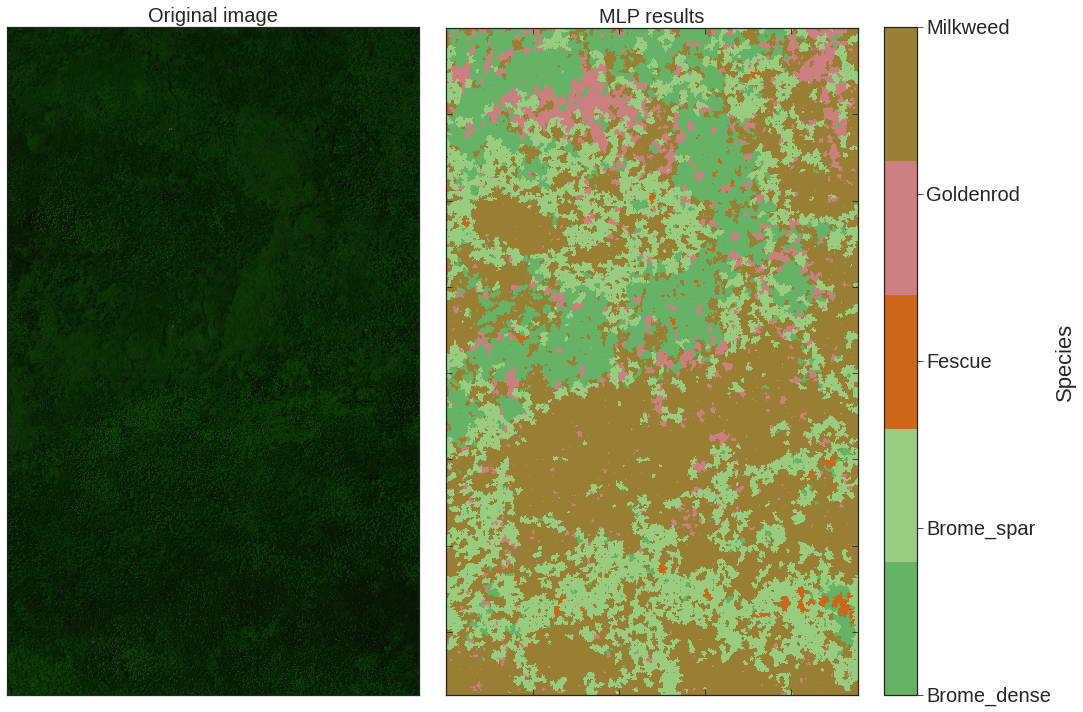

In [ ]:
# Display the classification results
plt.style.use('seaborn-ticks')

clf_mask = clf

# Set up species colors on the map
cm_clas = np.array([[0.4,0.7,0.4], [0.6,0.8,0.5], [0.8,0.4,0.1], [0.8,0.5,0.5], [0.6,0.5,0.2]])
cmap_clas = colors.ListedColormap(cm_clas)

# Plot the classification map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10), sharey=True)
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image', fontsize=20)
ax1.tick_params(labelbottom=False, labelleft=False, direction='in')  
clas_img = ax2.imshow(clf_mask, interpolation='none', cmap=cmap_clas)
ax2.set_title('MLP results', fontsize=20)
ax2.tick_params(bottom=True, top=True, left=True, right=True, labelbottom=False, labelleft=False, direction='in')
cbar = plt.colorbar(clas_img, ticks=[1,2,3,4,5])
cbar.set_label(label="Species", size=22)
cbar.ax.tick_params(labelsize=20, rotation=0, direction = 'out')
cbar.ax.set_yticklabels(labels=['Brome_dense', 'Brome_spar', 'Fescue', 'Goldenrod', 'Milkweed'], va="center")
fig.tight_layout()

# Export classification results to TIFF raster file
datype = gdal.GDT_Byte
output_fname = "/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/mlp_Class_result.tif"
write_geotiff(output_fname, clf_mask, datype, geo_transform, proj)


# Support Vector Machine Classification

In [ ]:
# SVM classification model tuning using RandomizedSearchCV
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import joblib
import pickle

start_time = time.time()

# Parameters for tuning
svm_params = {'kernel': ['rbf'],
              'C': [1e-1, 1e+0, 1e+1, 1e+2, 1e+3, 1e+4],
              'gamma': [1e-3, 1e-2, 1e-1, 1e+0, 1e+1]
              }

svm_grid = RandomizedSearchCV(estimator = svm.SVC(max_iter=3000), param_distributions=svm_params, cv=10,
                              n_iter=20, n_jobs=-1, verbose=1)

'''svm_grid = GridSearchCV(svm.SVC(max_iter=2000), param_grid=svm_params, cv=10,
                              n_jobs=-1, verbose=1)'''

svm_grid.fit(training_objects, training_labels)

# Print the tuning result and get the best parameters
print("The best parameters are %s with a score of %0.3f"
      % (svm_grid.best_params_, svm_grid.best_score_))

print("The best SVM model:")
print(svm_grid.best_estimator_)

means = svm_grid.cv_results_['mean_test_score']
stds = svm_grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svm_grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std*2, params))

# Save the trained best rfr model as a pickle file
path_svm = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/svm_model.pkl'
joblib.dump(svm_grid, open(path_svm, 'wb'))

# Calculate and save the training time
end_time = time.time()
elapsed_time = (end_time - start_time)

path_svm_time = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/svm_time_model.txt'
with open(path_svm_time, 'w', newline='') as txtfile:
  txtfile.write('Training time: ' + str(round(elapsed_time, 0)) + '\n')
  txtfile.write('Best model: ' + str(svm_grid.best_params_) + '\n')
  txtfile.write('Best score: ' + str(svm_grid.best_score_))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
The best parameters are {'kernel': 'rbf', 'gamma': 0.001, 'C': 10.0} with a score of 0.472
The best SVM model:
SVC(C=10.0, gamma=0.001, max_iter=3000)
0.281 (+/-0.046) for {'kernel': 'rbf', 'gamma': 10.0, 'C': 10.0}
0.442 (+/-0.136) for {'kernel': 'rbf', 'gamma': 0.001, 'C': 1.0}
0.281 (+/-0.046) for {'kernel': 'rbf', 'gamma': 0.1, 'C': 10000.0}
0.286 (+/-0.062) for {'kernel': 'rbf', 'gamma': 0.01, 'C': 1000.0}
0.281 (+/-0.046) for {'kernel': 'rbf', 'gamma': 0.1, 'C': 1000.0}
0.472 (+/-0.144) for {'kernel': 'rbf', 'gamma': 0.001, 'C': 10.0}
0.281 (+/-0.046) for {'kernel': 'rbf', 'gamma': 1.0, 'C': 1.0}
0.281 (+/-0.046) for {'kernel': 'rbf', 'gamma': 10.0, 'C': 100.0}
0.281 (+/-0.046) for {'kernel': 'rbf', 'gamma': 0.1, 'C': 0.1}
0.281 (+/-0.046) for {'kernel': 'rbf', 'gamma': 1.0, 'C': 0.1}
0.281 (+/-0.046) for {'kernel': 'rbf', 'gamma': 0.01, 'C': 1.0}
0.281 (+/-0.046) for {'kernel': 'rbf', 'gamma': 10.0, 'C': 1.0}
0.281 (

In [ ]:
# Load the model and perform classification
path_svm = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/svm_model.pkl'
svm_classifier =  joblib.load(open(path_svm, 'rb'))
svm_pred = svm_classifier.predict(objects)

# Copy resultant segments
clf = np.copy(segments)
for segment_id, clas in zip(objects_ids, svm_pred):
    clf[clf==segment_id] = clas

In [ ]:
# Calculate confusion matrix
# Plot confusion matrixfrom sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

predicted_labels = clf[for_verification]
cm = metrics.confusion_matrix(verification_labels, predicted_labels, normalize=None)
print_cm(cm, classes_labels)

kappa_svm = cohen_kappa_score(verification_labels, predicted_labels)
Overall_acc = accuracy_score(verification_labels, predicted_labels)
print()
print("Overall Accuracy:", round(Overall_acc*100, 3))
print("Kappa Coefficient:", round(kappa_svm, 3))

# Save runtime and accuracy to CSV
path_svm_txt = F'/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/svm_accuracy.txt'
with open(path_svm_txt, 'w', newline='') as txtfile:
  #row_write = csv.writer(csvfile, delimiter=' ')
  txtfile.write('Overall Accuracy: ' + str(round(Overall_acc*100, 3)) + '\n')
  txtfile.write('Kappa Coefficient: ' + str(round(kappa_svm, 3)))

print()
print('----------------------------------------------------------------------------------------------------------------------------')
print("Classification report:\n%s" %
      metrics.classification_report(verification_labels, predicted_labels,digits=3,
                                    target_names=classes_labels))

           	Brome_dense	 Brome_spar	     Fescue	  Goldenrod	   Milkweed	
Brome_dense	          9	          1	          0	          0	          3	
 Brome_spar	          3	          3	          0	          0	          3	
     Fescue	          1	          1	          3	          1	          1	
  Goldenrod	          0	          0	          0	          2	          4	
   Milkweed	          0	          2	          0	          0	         13	

Overall Accuracy: 60.0
Kappa Coefficient: 0.465

----------------------------------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

 Brome_dense      0.692     0.692     0.692        13
  Brome_spar      0.429     0.333     0.375         9
      Fescue      1.000     0.429     0.600         7
   Goldenrod      0.667     0.333     0.444         6
    Milkweed      0.542     0.867     0.667        15

    accuracy                          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


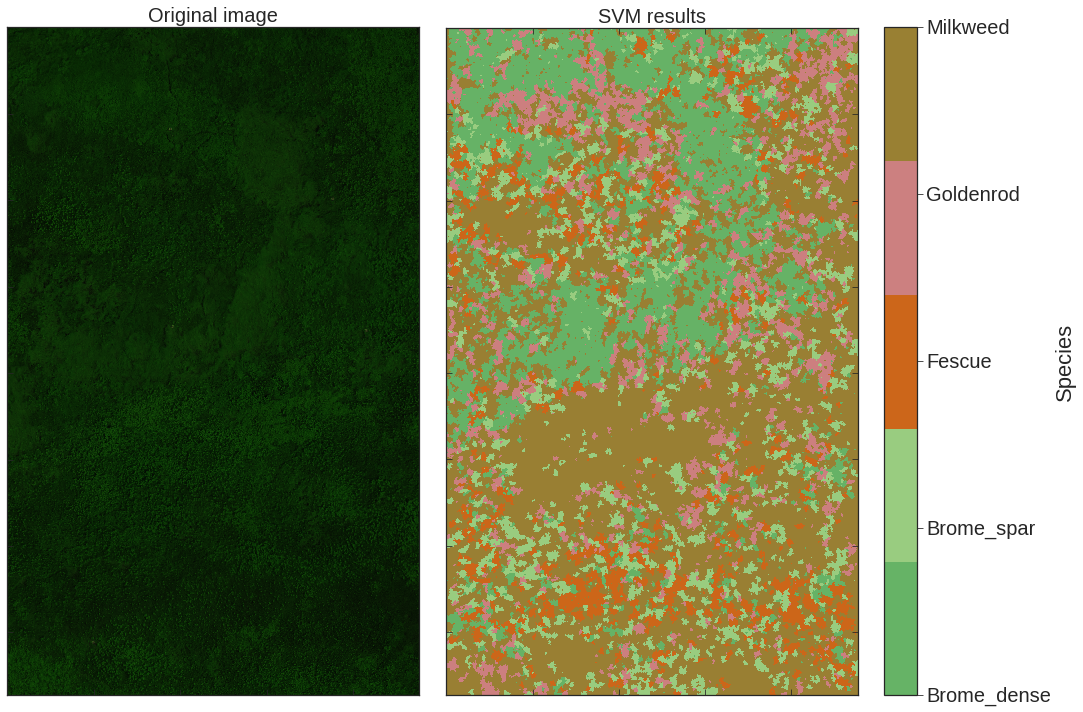

In [ ]:
# Display the classification results
plt.style.use('seaborn-pastel')

clf_mask = clf

# Set up species colors on the map
cm_clas = np.array([[0.4,0.7,0.4], [0.6,0.8,0.5], [0.8,0.4,0.1], [0.8,0.5,0.5], [0.6,0.5,0.2]])
cmap_clas = colors.ListedColormap(cm_clas)

# Plot the classification map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10), sharey=True)
ax1.imshow(rgb_img, interpolation='none')
ax1.set_title('Original image', fontsize=20)
ax1.tick_params(labelbottom=False, labelleft=False, direction='in')  
clas_img = ax2.imshow(clf_mask, interpolation='none', cmap=cmap_clas)
ax2.set_title('SVM results', fontsize=20)
ax2.tick_params(bottom=True, top=True, left=True, right=True, labelbottom=False, labelleft=False, direction='in')
cbar = plt.colorbar(clas_img, ticks=[1,2,3,4,5])
cbar.set_label(label="Species", size=22)
cbar.ax.tick_params(labelsize=20, rotation=0, direction = 'out')
cbar.ax.set_yticklabels(labels=['Brome_dense', 'Brome_spar', 'Fescue', 'Goldenrod', 'Milkweed'], va="center")
fig.tight_layout()

# Export classification results to TIFF raster file
datype = gdal.GDT_Byte
output_fname = "/content/gdrive/My Drive/Colab Notebooks/BII_Training/Species_Classification/Output_uav/svm_Class_result.tif"
write_geotiff(output_fname, clf_mask, datype, geo_transform, proj)


In [ ]:
# -------------The end